In [1]:
import itertools

import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import dataloader
import bandpower
import preprocessing

# Extract stress from excel

In [2]:
df = pd.read_csv('./data/SFC_DASS21.csv')
df.head()

,session,semester,subject,depression,anxiety,stress
0,'20140922_s1',1,1,18,20,38
1,'20141103_s1+s2',1,1,28,28,30
2,'20141201_s1+s2',1,1,34,34,32
3,'20141215_s1+s2',1,1,26,24,22
4,'20141229_s1+s2',1,1,36,26,30


In [3]:
df['stress'].describe()

count    171.000000
mean       7.450292
std        8.510315
min        0.000000
25%        0.000000
50%        4.000000
75%       12.000000
max       38.000000
Name: stress, dtype: float64

In [4]:
df[df['subject']<19]

,session,semester,subject,depression,anxiety,stress
0,'20140922_s1',1,1,18,20,38
1,'20141103_s1+s2',1,1,28,28,30
2,'20141201_s1+s2',1,1,34,34,32
3,'20141215_s1+s2',1,1,26,24,22
4,'20141229_s1+s2',1,1,36,26,30
...,...,...,...,...,...,...
89,'20141002_s17+s18',1,18,2,2,0
90,'20141023_s17+s18',1,18,0,2,0
91,'20141127_s17+s18',1,18,2,4,4
92,'20141211_s17+s18',1,18,2,2,0


In [8]:
# Get increased stress or normal label for each subject
num_sub = 26
group_mean = df.groupby(by='subject').mean()
labels = []

for i in range(len(df)):
    stress_sub = df.iloc[i]['stress']
    sub = df.iloc[i]['subject']
    threshold = group_mean.loc[sub]['stress']
    
    labels.append(stress_sub>threshold)
    
labels = np.asarray(labels, 'int')
df['label'] = labels
print('Label 1: %d, Label 0: %d'%(np.sum(labels), len(labels)-np.sum(labels)))

Label 1: 58, Label 0: 113


In [9]:
df.head()

,session,semester,subject,depression,anxiety,stress,label
0,'20140922_s1',1,1,18,20,38,1
1,'20141103_s1+s2',1,1,28,28,30,0
2,'20141201_s1+s2',1,1,34,34,32,1
3,'20141215_s1+s2',1,1,26,24,22,0
4,'20141229_s1+s2',1,1,36,26,30,0


## Extract EEG data from mat files

In [14]:
A, B, C = dataloader.read_data()

Load data from .mat files...


In [25]:
channels = sio.loadmat('./data/ch_lib.mat')
df = pd.DataFrame(columns = ['ID'] + list(range(30)))

for i in range(len(channels['ch_lib'])):
    channels_i = channels['ch_lib'][i][0][0]
    channels_select_i = [channels_i[i][0] for i in range(len(channels_i))]
    num_channel_i = len(channels_select_i)
    df.loc[i] = [i+1] + list(channels_select_i) + ['None']*(30-num_channel_i)
    

In [26]:
df

,ID,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,1,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
1,2,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
2,3,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
3,4,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8,None
4,5,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,167,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8
167,168,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8
168,169,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8
169,170,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8


In [6]:
channels_i = channels['ch_lib'][0][0][0]
channels_select_i = [channels_i[i][0] for i in range(len(channels_i))]
channels_select_i

['C3',
 'C4',
 'CP3',
 'CP4',
 'CPZ',
 'CZ',
 'F3',
 'F4',
 'F7',
 'F8',
 'FC3',
 'FC4',
 'FCZ',
 'FP1',
 'FP2',
 'FT7',
 'FT8',
 'FZ',
 'O1',
 'O2',
 'OZ',
 'P3',
 'P4',
 'PZ',
 'T3',
 'T4',
 'T5',
 'T6',
 'TP7',
 'TP8']

In [4]:
dataloader.find_common_channels()

['C4', 'CP3', 'CP4', 'F7', 'F8', 'FC4', 'FZ', 'P3']

# Extract DSS Stress level

In [57]:
subjects = list(range(1,27))
df_subs = pd.DataFrame()

for subject in subjects:
    if subject <= 18:
        file_path = './data/DSS/first semester/%s/first_datebystress%d.txt'%(str(subject).zfill(2), subject)
    else:
        file_path = './data/DSS/second semester/%s/second_datebystress%d.txt'%(str(subject-18).zfill(2), subject-18)

    df = pd.read_csv(file_path, sep = '\s+', header=0, names=['date','stress'], index_col=False)
    df['subject'] = [subject]*len(df)
    df_subs = df_subs.append(df)
    
df_subs = df_subs.reset_index(drop=True)

# Run t-test for resting spectrum between increase and normal stress

In [3]:

for label_format in range(1,4):
    # Load data
    EEG_list, labels, df_all = dataloader_pre.read_data(label_format=label_format)

    # Transform into band power
    low, high = list(range(1,50)), list(range(2,51))
    powers, psds, freqs = bandpower.get_bandpower(EEG_list, 1000, low, high, dB_scale=True)

    # Seperate two groups and average over channels
    increase_group, normal_group = [], []
    for i, power in enumerate(powers):

        # Average over channels
        avg = np.mean(power, axis=0)

        if labels[i] == 1:
            increase_group.append(avg)
        else:
            normal_group.append(avg)

    increase_group = np.array(increase_group)
    normal_group = np.array(normal_group)

    mean_inc, std_inc = np.mean(increase_group, axis=0), np.std(increase_group, axis=0)
    mean_nor, std_nor = np.mean(normal_group, axis=0), np.std(normal_group, axis=0)

    freqs = range(1,50)
    plt.plot(freqs, mean_inc, 'r-', label='Increased')
    plt.plot(freqs, mean_nor, 'b-', label='Normal')
    plt.plot(freqs, mean_inc+std_inc, 'r--', freqs, mean_inc-std_inc, 'r--')
    plt.plot(freqs, mean_nor+std_nor, 'b--', freqs, mean_nor-std_nor, 'b--')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB)')
    plt.title('Stress')
    plt.legend()
    plt.savefig('./results/PSD_label%d.png'%(label_format))
    plt.close()
    
    # Run t-test
    ttest_result = stats.ttest_ind(increase_group, normal_group)
    
    plt.plot(freqs, ttest_result.pvalue)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('pvalue')
    plt.title('Unpaired t-test (%d)'%(label_format))
    plt.savefig('./results/t-test_label%d.png'%(label_format))
    plt.close()

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]
Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]
Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [4]:
# Plot psd of each trial
indices = np.where(freqs<50)[0]
psds = [psds[i][:,indices] for i in range(len(psds))]
freqs = freqs[indices]

for i in range(len(powers)):
    plt.figure()
    for j in range(powers[i].shape[0]):
        plt.plot(freqs,psds[i][j,:])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB)')
    plt.title('PSD of No.%d trial'%(i))
    plt.savefig('./results/psd_raw_images/psd_%d.png'%(i))
    plt.close()
    

# Compare labels based on three criteria

In [3]:
labels = {}
for i in range(1,4):
    _, Y, _ = dataloader.read_data(label_format=i)
    labels['Label%d'%(i)] = Y
    
df = pd.DataFrame(labels)
df.to_csv('./results/labels.csv')

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 2.496e+02 2.498e+02 2.500e+02]


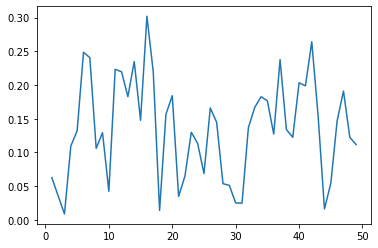

In [4]:
fs = 500
t = np.linspace(0,60,60*fs)
signal = 0
for i in range(1,51):
    signal += np.random.rand()*np.cos(2*np.pi*i*t)
signal = [signal[np.newaxis,:]]

low, high = list(range(1,50)), list(range(2,51))
powers = bandpower.get_bandpower(signal, fs, low, high)

freqs = range(1,50)
plt.plot(freqs,powers[0][0])

# Get correlation of each bandpower

In [5]:
EEG_list, labels, df_all = dataloader.read_data(label_format=1)

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [26]:
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(EEG_list, 1000, low, high, dB_scale=True)

Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [27]:
# Average over channels
powers = np.array([np.mean(powers[i], axis=0) for i in range(len(powers))])

In [28]:
corr_data = np.corrcoef(powers.T)
print('Ratio of elements with absolute correlation greater than 0.9: %.3f'
      %(np.sum(np.abs(corr_data)>0.9)/np.size(corr_data)))

Ratio of elements with absolute correlation greater than 0.9: 0.969


<AxesSubplot:>

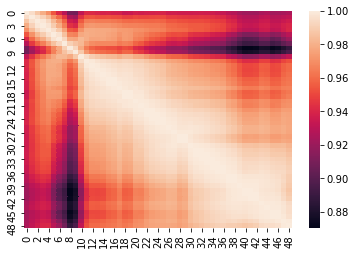

In [29]:
sns.heatmap(np.abs(corr_data))

# Average over 6 regions

In [34]:
nuAmps_channels = pd.read_csv('./data/30ch_loc_NuAmps.csv')['label'].values
synAmps_channels = pd.read_csv('./data/30ch_loc_SynAmps2.csv')['label'].values

In [37]:
print('nuAmps channels not in synAmps:')
for i in range(len(nuAmps_channels)):
    if nuAmps_channels[i] not in synAmps_channels:
        print(nuAmps_channels[i])

nuAmps channels not in synAmps:
'T3'
'T4'
'T5'
'T6'


In [38]:
print('synAmps channels not in nuAmps:')
for i in range(len(synAmps_channels)):
    if synAmps_channels[i] not in nuAmps_channels:
        print(synAmps_channels[i])

synAmps channels not in nuAmps:
'T7'
'T8'
'P7'
'P8'


T3 = T7, T4 = T8, T5 = P7, T6 = P8

In [50]:
regions_nuAmps = [[] for i in range(6)]
regions_synAmps = [[] for i in range(6)]

for channel in synAmps_channels:
    #print(channel)
    channel = channel.replace('\'', '')
    if channel[0] == 'F':
        regions_synAmps[0].append(channel)
    elif channel[0] == 'C':
        regions_synAmps[2].append(channel)
    elif channel[0] == 'P' or channel in ['T5','T6']:
        regions_synAmps[4].append(channel)
    elif channel[0] == 'O':
        regions_synAmps[5].append(channel)
    elif channel[0] == 'T' and int(channel[-1])%2 == 1:
        regions_synAmps[1].append(channel)
    else:
        regions_synAmps[3].append(channel)

In [9]:
EEG_list, labels, df_all = dataloader.read_data(label_format = 1, data_folder='rawdata')

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [25]:
EEG_regions_list = []

for i in range(len(EEG_list)):
    EEG_regions = np.zeros((6, EEG_list[i].shape[1]))
    indices_channels = [[] for i in range(6)]
    
    for j in range(EEG_list[i].shape[0]):
        channel = df_all.loc[i, 'channels'][j]
        
        if channel[0] == 'F':
            indices_channels[0].append(j)
        elif channel[0] == 'C':
            indices_channels[2].append(j)
        elif channel[0] == 'P' or channel in ['T5','T6']:
            indices_channels[4].append(j)
        elif channel[0] == 'O':
            indices_channels[5].append(j)
        elif channel[0] == 'T' and int(channel[-1])%2 == 1:
            indices_channels[1].append(j)
        else:
            indices_channels[3].append(j)
    
    for i_region in range(6):
        EEG_regions[i_region,:] = np.mean(EEG_list[i][indices_channels[i_region],:], axis=0)
        
    EEG_regions_list.append(EEG_regions)

# Plot PSD for all trials

In [2]:
EEG_list, labels, df_all = dataloader.read_data(label_format=1, data_folder='rawdata')
low, high = list(range(1,50)), list(range(2,51))
_, psds, freqs = bandpower.get_bandpower(EEG_list, 1000, low, high, dB_scale=True)

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [13]:
# Select PSD<50
indices = np.where(freqs<50)[0]
psds = [psd[:,indices] for psd in psds]
freqs = freqs[indices]

for i_trial in range(len(psds)):
    
    for i_channel in range(len(psds[i_trial])):
        plt.plot(freqs, psds[i_trial][i_channel])
    plt.savefig('./results/PSD_raw_images_label1/PSD_trial_%d'%(i_trial))
    plt.close()

In [11]:
# Identify bad trials by visual inspection
bad_trials = {96, 97, 101, 109, 111, 113, 115, 116, 119, 141, 147, 164}

12

In [12]:
new_EEG, new_labels, new_df = preprocessing.remove_trials(EEG_list, labels, df_all, bad_trials)
print('Trials: %d -> %d'%(len(EEG_list),len(new_EEG)))

Trials: 169 -> 157


# Run t-test after removing bad trials and average over regions

In [4]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
save_folder = 'PSD_rest_images'

for label_format in range(4, 5):
    # Load data
    EEG_list, labels, df_all = dataloader.read_data(label_format=label_format, data_folder='rest')
    data = preprocessing.StressData(EEG_list, labels, df_all)

    # Remove bad trials
    if label_format != 4:
        data.remove_trials()
    
    # Average into regions
    data.avg_channels_into_regions(mode = 1)
    
    # Transform into band power
    low, high = list(range(1,50)), list(range(2,51))
    powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low, high, dB_scale=True)
    indices = np.where(freqs<50)[0]
    psds = [psd[:,indices] for psd in psds]
    freqs = freqs[indices]
    
    # Seperate two groups and average over channels
    increase_group = np.array([psds[i] for i in range(len(psds)) if data.labels[i]==1])
    normal_group = np.array([psds[i] for i in range(len(psds)) if data.labels[i]==0])

    mean_inc, std_inc = np.mean(increase_group, axis=0), np.std(increase_group, axis=0)
    mean_nor, std_nor = np.mean(normal_group, axis=0), np.std(normal_group, axis=0)

    num_regions = mean_inc.shape[0]
    for i in range(num_regions):
        plt.plot(freqs, mean_inc[i,:], 'r-', label='inc')
        plt.plot(freqs, mean_nor[i,:], 'b-', label='nor')
        
        plt.plot(freqs, mean_inc[i,:]+std_inc[i,:], 'r--', alpha=0.5)
        plt.plot(freqs, mean_inc[i,:]-std_inc[i,:], 'r--', alpha=0.5)
        plt.plot(freqs, mean_nor[i,:]+std_nor[i,:], 'b--', alpha=0.5)
        plt.plot(freqs, mean_nor[i,:]-std_nor[i,:], 'b--', alpha=0.5)
        
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD (dB)')
        plt.title('Stress of region %s'%(df_all['channels'][0][i]))
        plt.legend()
        plt.savefig('./results/%s/PSD_label%d_region_%s.png'%(save_folder, label_format, data.df_all['channels'][0][i]))
        plt.close()
    
    # Run t-test
    ttest_result = stats.ttest_ind(increase_group, normal_group)
    
    for i in range(num_regions):
        plt.plot(freqs, ttest_result.pvalue[i,:], color=colors[i], linestyle='-')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('pvalue')
        plt.title('Unpaired t-test (%d) of region %s'%(label_format,data.df_all['channels'][0][i]))
        plt.savefig('./results/%s/t-test_label%d_region_%s.png'%(save_folder, label_format,data.df_all['channels'][0][i]))
        plt.close()

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


# Cluster data by K-means and GMM

In [5]:
def plot_components(components, labels, df_all, title):
    
    num_components = components.shape[1]
    # Plot PCA components for each channel
    fig, axs = plt.subplots(num_components//3,3, figsize=(10,num_components))
    for i_channel in range(num_components):

        labels_sub = labels[:,i_channel] if labels.ndim==2 else labels
        row, col = i_channel//3, i_channel%3

        nor_indices = np.where(labels_sub==0)[0]
        inc_indices = np.where(labels_sub==1)[0]

        axs[row][col].scatter(components[nor_indices,i_channel,0], components[nor_indices,i_channel,1], .8, color='r')
        axs[row][col].scatter(components[inc_indices,i_channel,0], components[inc_indices,i_channel,1], .8, color='b')
        axs[row][col].legend(['normal','increase'])
        axs[row][col].set_title(df_all.loc[0,'channels'][i_channel])

    fig.suptitle(title)
    fig.text(0.5, 0.05, '1st component', ha='center')
    fig.text(0.05, 0.5, '2nd component', va='center', rotation='vertical')
    

In [8]:
# 1: average into 6 regions
# 2: rereference on CZ and average into 9 regions
mode = 1
label_format = 4
data_folder = 'rest'

In [12]:
# Standard PCA for PSD
EEG_list, labels, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
data = preprocessing.StressData(EEG_list, labels, df_all)

# Remove bad trials
if label_format != 4:
    data.remove_trials()

# Average into regions
if mode == 2:
    data.reReference('CZ')
data.avg_channels_into_regions(mode=mode)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
psds = np.array(psds)
'''
psds = psds[..., freqs<10]
freqs = freqs[freqs<10]
'''

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


'\npsds = psds[..., freqs<10]\nfreqs = freqs[freqs<10]\n'

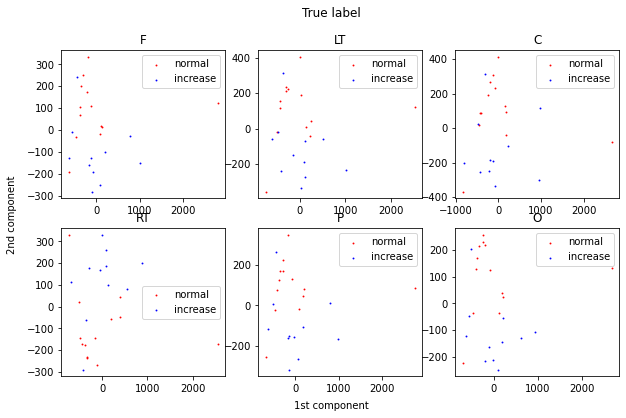

In [14]:
# PCA for each regions and select first and second component
num_sample, num_channel = psds.shape[0], psds.shape[1]
psds_PCA = np.zeros((num_sample, num_channel, 2))
pca = PCA(n_components=2)
for i in range(num_channel):
    psds_PCA[:,i,:] = pca.fit_transform(psds[:,i,:])

plot_components(psds_PCA, data.labels, data.df_all, 'True label')

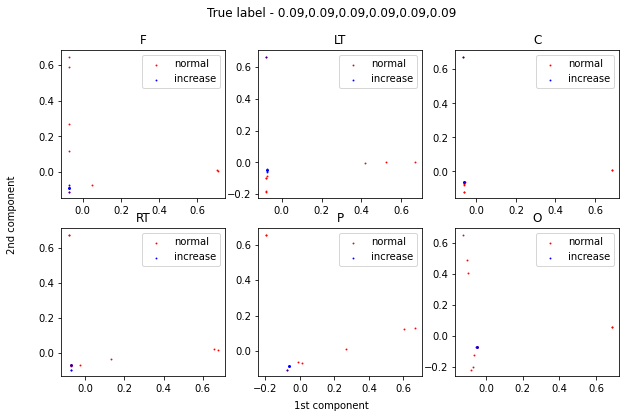

In [16]:
# Kernal PCA for each regions and select first and second component
variances = []
num_sample, num_channel = psds.shape[0], psds.shape[1]
psds_PCA = np.zeros((num_sample, num_channel, 2))
pca = KernelPCA(kernel='rbf')
for i in range(num_channel):
    psds_PCA[:,i,:] = pca.fit_transform(psds[:,i,:])[:,:2]
    ev = pca.lambdas_
    variances.append('%.2f'%((ev[0]+ev[1])/np.sum(ev)))
    
title = 'True label - ' + ','.join(variances)
    
plot_components(psds_PCA, data.labels, data.df_all, title)

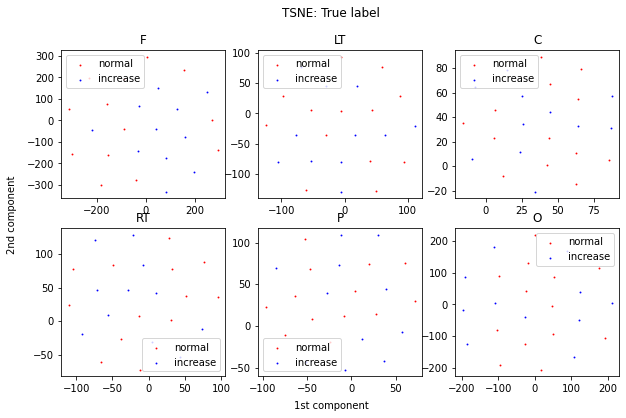

In [17]:
'''
# T-SNE for PSD after kernelPCA
EEG_list, labels, df_all = dataloader.read_data(label_format=1)

# Remove bad trials
EEG_list, labels, df_all = preprocessing.remove_trials(EEG_list, labels, df_all)

# Average into regions
if mode == 2:
    EEG_list, labels, df_all = preprocessing.reReference(EEG_list, labels, df_all, 'CZ')
EEG_list = preprocessing.avg_channels_into_regions(EEG_list, df_all, mode=mode)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(EEG_list, 1000, low=low, high=high, dB_scale=True)
psds = np.array(psds)
psds = psds[..., freqs<10]
freqs = freqs[freqs<10]
'''

# T-SNE for each regions and select first and second component
num_sample, num_channel = psds.shape[0], psds.shape[1]
psds_tsne = np.zeros((num_sample, num_channel, 2))
tsne = TSNE(n_components = 2)
for i in range(num_channel):
    psds_tsne[:,i,:] = tsne.fit_transform(pca.fit_transform(psds[:,i,:]))
    
title = 'TSNE: True label'
    
plot_components(psds_tsne, data.labels, data.df_all, title)

Kmeans inertia:  [1.0172244252545168, 1.0326347819889918, 1.0029033220012997, 1.0138265027531215, 1.035917262706947, 1.0182409426861363]
Kmeans accuracy:  [0.4583333333333333, 0.4166666666666667, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333]


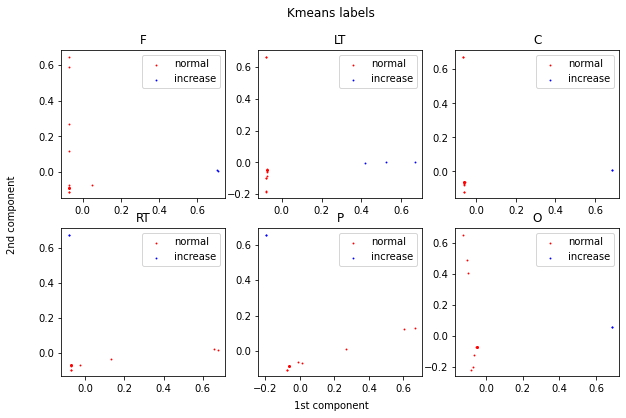

In [19]:
# K-means of kernel PCA components for 2 clusters
kmeans_labels = np.zeros((num_sample, num_channel))
kmeans_inertia = []
kmeans_acc = []

for i in range(num_channel):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(psds_PCA[:,i,:])
    kmeans_labels[:,i] = kmeans.labels_
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_acc.append(np.sum(kmeans.labels_==data.labels)/num_sample)
    
print('Kmeans inertia: ', kmeans_inertia)
print('Kmeans accuracy: ', kmeans_acc)
plot_components(psds_PCA, kmeans_labels, data.df_all, 'Kmeans labels')

GMM log-likelihood:  [1.4376965834093383, 2.4992969158018945, 3.265198071565529, 3.926219054135187, 4.223849450386104, 3.6399078076001334]
GMM accuracy:  [0.4583333333333333, 0.5416666666666666, 0.5416666666666666, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333]


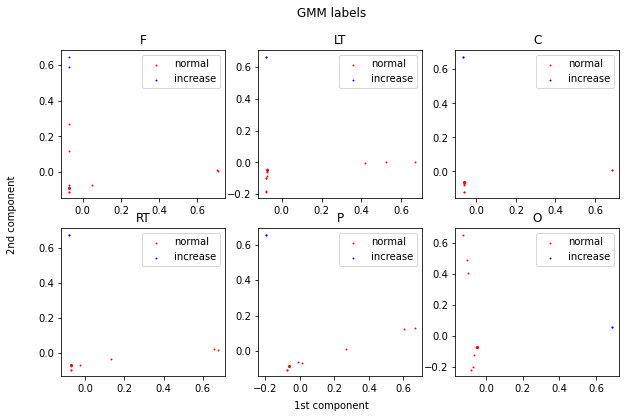

In [21]:
# GMM of kernel PCA for 2 clusters
gmm_labels = np.zeros((num_sample, num_channel))
gmm_likelihood = []
gmm_acc = []

for i in range(num_channel):
    X = psds_PCA[:,i,:]
    gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
    gmm_labels[:,i] = gmm.predict(X)
    gmm_likelihood.append(gmm.score(X))
    gmm_acc.append(np.sum(gmm_labels[:,i]==data.labels)/num_sample)
    
plot_components(psds_PCA, gmm_labels, data.df_all, 'GMM labels')
print('GMM log-likelihood: ', gmm_likelihood)
print('GMM accuracy: ', gmm_acc)

Text(0.09, 0.5, 'PC2')

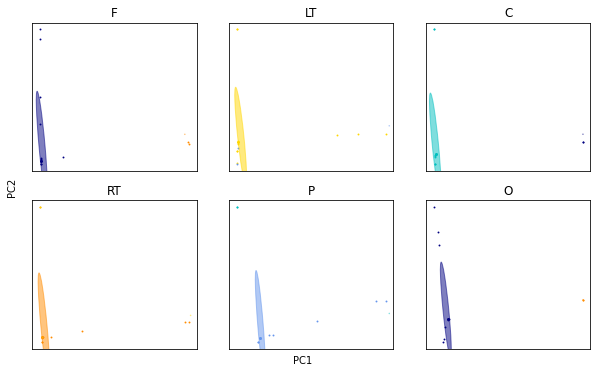

In [22]:
color_iter = itertools.cycle(['navy', 'darkorange', 'gold', 'cornflowerblue', 'c'])
def plot_results(X, Y_, means, covariances, index, title): 
    splot = plt.subplot(num_channel//3, 3, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
        means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi # convert to degrees
        ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color) 
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    
fig = plt.figure(figsize=(10,6))
for i_channel in range(num_channel):
    X = psds_PCA[:,i,:]
    gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
    gmm_labels = gmm.predict(X)
    
    plot_results(psds_PCA[:,i_channel,:], gmm_labels, gmm.means_, gmm.covariances_, i_channel, data.df_all.loc[0,'channels'][i_channel])
    
fig.text(0.5, 0.09, 'PC1', ha='center')
fig.text(0.09, 0.5, 'PC2', va='center', rotation='vertical')

# See the distribution of PSD of both groups

In [2]:
EEG_list, labels, df_all = dataloader.read_data(label_format=2)

# Remove bad trials
EEG_list, labels, df_all = preprocessing.remove_trials(EEG_list, labels, df_all)

# Average into regions
EEG_list = preprocessing.avg_channels_into_regions(EEG_list, df_all)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(EEG_list, 1000, low=low, high=high, dB_scale=True)
psds = np.array(psds)
psds = psds[..., freqs<50]
freqs = freqs[freqs<50]

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [10]:
i_inc = np.where(labels==1)[0]
i_nor = np.where(labels==0)[0]

for i in range(len(freqs)):
    
    psd = psds[..., i]
    fig, axs = plt.subplots(2, 3, figsize=(10,6))
    
    for i_channel in range(psd.shape[1]):
        
        row, col = i_channel//3, i_channel%3
        axs[row,col].hist(psd[i_nor,i_channel], color='r', bins=20, label='normal', density=True, alpha=0.5)
        axs[row,col].hist(psd[i_inc,i_channel], color='b', bins=20, label='increase', density=True, alpha=0.5)
        axs[row,col].set_title(df_all.loc[0,'channels'][i_channel])
        axs[row,col].legend()
        
    fig.suptitle('Freq: %.2f Hz'%(freqs[i]))
    fig.text(0.5, 0.05, 'PSD (dB)', ha='center')
    fig.text(0.05, 0.5, 'Density', va='center', rotation='vertical')
    fig.savefig('./results/PSD_raw_distribution/%d.png'%(i))
    plt.close()

# Analyze which frequency does L1 choose

Load data from .mat files...
Remove trials:
Number: 41, Session: 20141013, Subject: 7
Number: 47, Session: 20141013, Subject: 8
Remove trials:
Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


Text(0.05, 0.5, 'Coefficients')

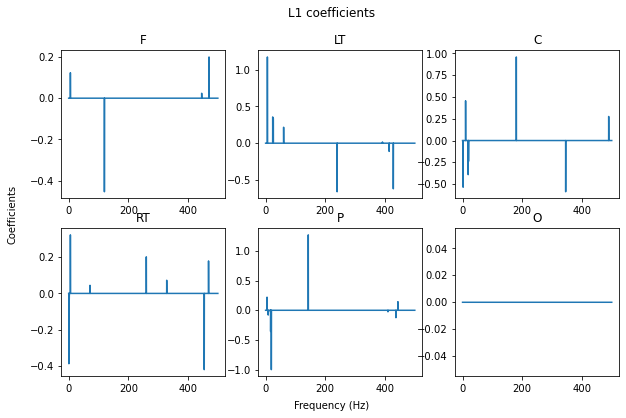

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

label_format = 2
data_folder = 'bp_ica_only'

X, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
data = preprocessing.StressData(X, Y, df_all)
    
# Remove bad trials
if data_folder == 'rawdata':
    data.remove_trials

# Average channels
data.avg_channels_into_regions(mode=1)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
inputs = psds
xaxis = freqs

# L1 feature selection
inputs = np.array(inputs)
inputs = inputs.reshape((inputs.shape[0],-1))
scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(inputs, data.labels)
indices = np.where(sel_.estimator_.coef_!=0)[1]

fig, axs = plt.subplots(2, 3, figsize=(10,6))
for i_channel in range(6):

    row, col = i_channel//3, i_channel%3

    axs[row][col].plot(xaxis, sel_.estimator_.coef_[0,i_channel*len(xaxis):(i_channel+1)*len(xaxis)])
    axs[row][col].set_title(data.df_all.loc[0,'channels'][i_channel])

fig.suptitle('L1 coefficients')
fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
fig.text(0.05, 0.5, 'Coefficients', va='center', rotation='vertical')

In [ ]:
for i in range(6):
    print('In %s region: '%(data.df_all.loc[i, 'channels']))
    print(freqs)

# Analyze stress before and after stress

In [2]:
_, Y, df = dataloader.read_data(label_format=2, data_folder='rest')

Load data from .mat files...


In [4]:
inc, dec, static = 0, 0, 0

for i in range(len(df)//2):
    before, after = df.loc[i*2+1, 'stress'], df.loc[i*2, 'stress']
    if before > after:
        dec += 1
    elif before < after:
        inc += 1
    else:
        static += 1

5, 7, 14


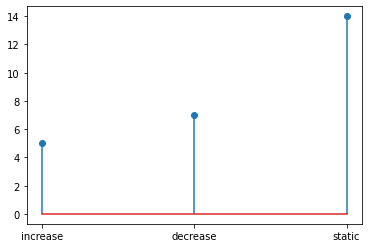

In [5]:
plt.stem(['increase', 'decrease', 'static'],[inc, dec, static])
print('%d, %d, %d'%(inc, dec, static))

In [10]:
print('Label: %d'%(2))
print('DASS Stress <= 14: %d'%(np.sum(Y==0)))
print('DASS Stress >  14: %d'%(np.sum(Y==1)))

Label: 2
DASS Stress <= 14: 52
DASS Stress >  14: 0


In [12]:
# Output csv recording state change for each trial
sessions = []
labels = []
df = df.sort_values(by=['subject', 'session', 'period']).reset_index(drop=True)

for i in range(len(df)//2):
    
    before, after = df.loc[i*2+1, 'stress'], df.loc[i*2, 'stress']
    session = df.loc[i*2, 'fileName'][:12]
    if before < after:
        label = 1
    elif before > after:
        label = -1
    else:
        label = 0
    sessions.append(session)
    labels.append(label)
    
df_state = pd.DataFrame({'session':sessions, 'label': labels})
df_state.to_csv('./DASS_before_after_change.csv')
    

# Calculate similarity of EEG before and after exam

In [12]:
EEG_list, _, df = dataloader.read_data(label_format=2, data_folder='rest')

# Transform into psd
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(EEG_list, 1000, low=low, high=high, dB_scale=True)

Load data from .mat files...
Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [79]:
df_new = df.loc[::2, ['session','subject','channels']].reset_index(drop=True)
labels, sims = [], []
for i in range(len(df)//2):
    before_stress, after_stress = df.loc[i*2+1, 'stress'], df.loc[i*2, 'stress']
    before_power, after_power = powers[i*2+1].reshape((1,-1)), powers[i*2].reshape((1,-1))
    
    # Calculate similarity
    similarity = cosine_similarity(before_power, after_power)[0,0]
    
    # Calculate label (inc: 1, static: 0, dec: -1)
    if before_stress > after_stress:
        label = -1
    elif before_stress < after_stress:
        label = 1
    else:
        label = 0
        
    labels.append(label)
    sims.append(similarity)
    
df_new['stress_variation'] = labels
df_new['similarity'] = sims

df_new.to_csv('./results/rest_similarity.csv')

Stress variation: 1
Mean, Std: 0.944942, 0.035971
Stress variation: 0
Mean, Std: 0.971319, 0.028659
Stress variation: -1
Mean, Std: 0.976004, 0.018200


Text(0, 0.5, 'Mean of similarity')

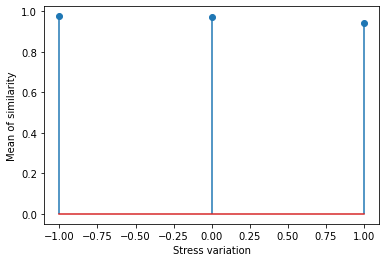

In [80]:
# Similarity for each stress variation
df_new = df_new.drop(22)    # Drop weird stress variation
variations = [1,0,-1]
means = []
for variation in variations:
    print('Stress variation: %d'%(variation))
    
    sims = df_new[df_new['stress_variation']==variation]['similarity'].values
    means.append(np.mean(sims))
    print('Mean, Std: %f, %f'%(np.mean(sims), np.std(sims)))
    
plt.stem(variations, means)
plt.xlabel('Stress variation')
plt.ylabel('Mean of similarity')

Subject: 19
Mean, Std: 0.978055, 0.016551
Subject: 20
Mean, Std: 0.989148, 0.001707
Subject: 21
Mean, Std: 0.989873, 0.004606
Subject: 22
Mean, Std: 0.952606, 0.001331
Subject: 23
Mean, Std: 0.923727, 0.032550
Subject: 24
Mean, Std: 0.976911, 0.007359
Subject: 25
Mean, Std: 0.908032, 0.026359


Text(0, 0.5, 'Similarity')

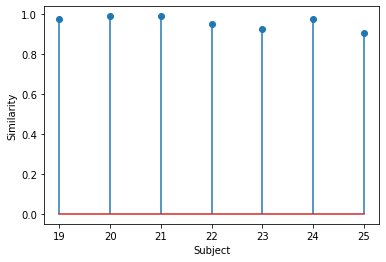

In [81]:
# Similarity for each subject
means = []
subjects = list(range(19,26))
for subject in subjects:
    print('Subject: %d'%(subject))
    
    sims = df_new[df_new['subject']==subject]['similarity'].values
    means.append(np.mean(sims))
    print('Mean, Std: %f, %f'%(np.mean(sims), np.std(sims)))
    
plt.stem(subjects, means)
plt.xlabel('Subject')
plt.ylabel('Similarity')

# T-test for EEG before and after exam

In [86]:
EEG_list, Y, df = dataloader.read_data(label_format=2, data_folder='rest')
data = preprocessing.StressData(EEG_list, Y, df)

# Average into 6 regions
data.avg_channels_into_regions(mode = 1)

# Transform into psd
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)

powers = np.array(powers).reshape((len(powers), -1))

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [89]:
before_powers, after_powers = [], []
labels = []

# Seperate before, after power and stress variation
for i in range(len(powers)//2):
    
    before_stress, after_stress = data.df_all.loc[i*2+1, 'stress'], data.df_all.loc[i*2, 'stress']
    before_power, after_power = powers[i*2+1].reshape((1,-1)), powers[i*2].reshape((1,-1))
    
    if before_stress > after_stress:
        label = -1
    elif before_stress < after_stress:
        label = 1
    else:
        label = 0
        
    before_powers.append(before_power)
    after_powers.append(after_power)
    labels.append(label)
    
[before_powers, after_powers, labels] = [np.array(x) for x in [before_powers, after_powers, labels]]

In [144]:
variations = [1, 0, -1]
ttest_result = []

for variation in variations:
    
    indices = np.where(labels==variation)[0]
    ttest_result.append(stats.ttest_ind(before_powers[indices], after_powers[indices]).pvalue)

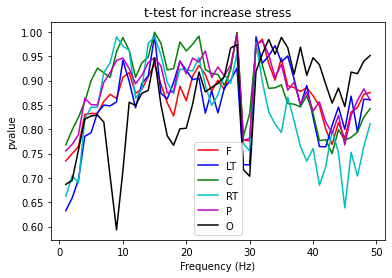

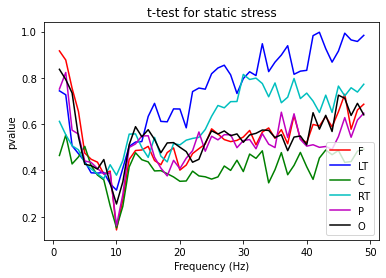

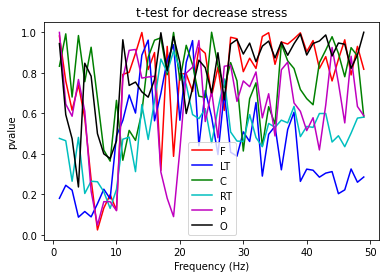

In [145]:
# Plot ttest figures
freq = list(range(1,50))
colors = ['r', 'b', 'g', 'c', 'm', 'k']
for i, variation in enumerate(['increase', 'static', 'decrease']):
    
    plt.figure()
    
    for i_region in range(6):
        pvalues = ttest_result[i][0][i_region*len(freq):(i_region+1)*len(freq)]
        plt.plot(freq, pvalues, color=colors[i_region])
        
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('pvalue')
    plt.legend(data.df_all.loc[0,'channels'])
    plt.title('t-test for %s stress'%(variation))
    
    plt.savefig('./results/rest_ttest/ttest_%s.png'%(variation))

# Analyze responder and non-responder by stress and anxiety

In [2]:
_, labels, df_all = dataloader.read_data(label_format=2, data_folder='rawdata')

Load data from .mat files...


In [3]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
slopes = []
corrcoefs = []

for subject in df_all['subject'].unique():
    info_subject = df_all[df_all['subject']==subject]
    model = LinearRegression(fit_intercept=False)
    x = info_subject['anxiety'].values.reshape((len(info_subject), 1))
    y = info_subject['stress'].values.reshape((len(info_subject), 1))
    
    model.fit(x, y)
    m = model.coef_[0,0]
    r = np.corrcoef(x.flatten(), y.flatten())[0,1] if m!=0 else 0
    
    slopes.append(m)
    corrcoefs.append(r)
    if model.coef_[0] <= 1:
        fit_x, fit_y = 42, m*42 
    else:
        fit_x, fit_y = 42/m if m!=0 else 0, 42
    
    plt.plot(x, y, 'o')
    plt.plot([0,fit_x], [0,fit_y], 'b-', alpha=0.5)
    plt.plot([0,42],[0,42], 'r-', alpha=0.5)
    plt.legend(['sample', 'm=%.2f'%(m), 'm=1'])
    plt.xlim([0,42])
    plt.ylim([0,42])
    plt.title('Subject %d: r = %.2f'%(subject, r))
    plt.xlabel('anxiety')
    plt.ylabel('stress')
    plt.savefig('./results/anxiety_stress/%d.png'%(subject))
    plt.close()
    

In [11]:
df = pd.DataFrame({'subject':df_all['subject'].unique(), 'slopes': slopes, 'corr_coef': corrcoefs})

# Define labels of responder or non-responder
# Remove subjects with correlation coefficient < 0.5 (label: 0)
# slope>1 (label: 1), slope<=1 (label: -1)
labels = []
for i in range(len(slopes)):
    if corrcoefs[i] < 0.5:
        labels.append(0)
    elif slopes[i] > 1:
        labels.append(1)
    else:
        labels.append(-1)

df['label'] = labels

In [13]:
df.to_csv('./results/anxiety_stress.csv')

# Analyze L1 selected features

In [15]:
feature = 'BP'
regions = ['F','LT','C','RT','P','O']
df = pd.read_csv('./results/L1_%s/select.csv'%(feature),converters={region: lambda x: x.strip("[]").split(", ") for region in regions})
df = df.drop(columns=df.columns[0], axis=1)

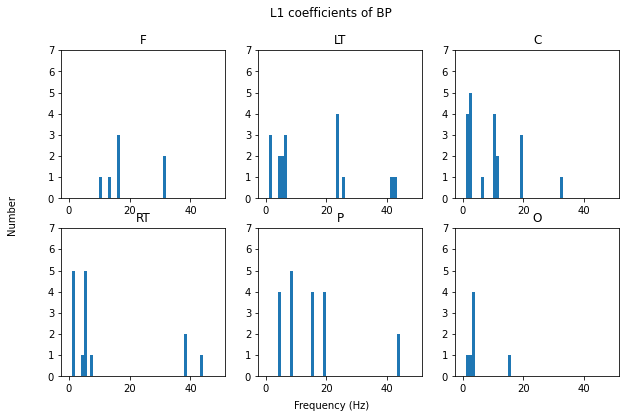

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for i_region, region in enumerate(regions):
    
    row, col = i_region//3, i_region%3
    features = []
    for i in range(len(df)):
        if df.loc[i, region][0] != '':
            features += map(float, df.loc[i, region])
    
    axs[row][col].hist(features, bins=list(range(50)))
    axs[row][col].set_title(region)
    axs[row][col].set_ylim(0, 7)
    
fig.suptitle('L1 coefficients of %s'%(feature))
fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
fig.text(0.05, 0.5, 'Number', va='center', rotation='vertical')
fig.savefig('./results/L1_%s/hist.png'%(feature))